In [1]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
import pandas as pd
from tqdm.notebook import tqdm
import os, re, math

In [2]:
%cd ../paper
%pwd

/Users/hidde/IdeaProjects/fl-project-code/paper


'/Users/hidde/IdeaProjects/fl-project-code/paper'

In [3]:
# PAPER_DIR = "./../../fl-project"
PAPER_DIR = "."

output_dir = PAPER_DIR + "/plots"

#pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', 500)

def setup_plt():

    fig_width_pt = 220  # Get this from LaTeX using \showthe
    inches_per_pt = 1.0 / 72.27 * 2  # Convert pt to inches
    golden_mean = ((np.math.sqrt(5) - 1.0) / 2.0) * .8  # Aesthetic ratio
    fig_width = fig_width_pt * inches_per_pt  # width in inches
    fig_height = (fig_width * golden_mean)  # height in inches
    fig_size =  [fig_width, fig_height]

    plt_params = {
        'backend': 'ps',
        'axes.labelsize': 20,
        'legend.fontsize': 16,
        'xtick.labelsize': 18,
        'ytick.labelsize': 18,
        'font.size': 18,
        'figure.figsize': fig_size,
        'font.family': 'Times New Roman'
    }

    plt.rcParams.update(plt_params)
    plt.rc('pdf', fonttype=42)  # IMPORTANT to get rid of Type 3


In [5]:

# build benchmarks

cagg_config = {
    "server_label": "aggregate commitment",
    "color": "0.1"
}
wellformed_config = {
    "client_label": "create well-formedness proof",
    "server_label": "verify well-formedness proof",
    "color": "0.3"
}
range_config = {
    "client_label": "create range proof",
    "server_label": "verify range proof",
    "color": "0.5"
}



def extract(filename, pattern, label, data_dir, fixed_point_repr=None):
    # pattern group(1) represents fixed_point_repr
    # pattern group(2) represents n_weights

    lst = []
    match = re.search(pattern, filename, re.IGNORECASE)
    if match:
        # extract the weight parameter and the fp-repr
        group1 = int(match.group(1))

        if fixed_point_repr is None:
            fixed_point_repr = group1
            n_weights = int(match.group(2))
        else:
            fixed_point_repr = fixed_point_repr
            n_weights = group1

        
        # read the benchmark result file
        with open(f"{data_dir}/{filename}", "r") as f:
            lines = f.readlines()
            results =  [int(x) for x in lines]
        
        # go through results and write dicts 
        for i, result in enumerate(results):
            d = {
                "repetition": i,
                "fixed_point_repr" : fixed_point_repr,
                "n_weights": n_weights,
                label: result
            }               

            lst.append(d)
    
    return lst
    


def build_df_mbench_computation():

    df1 = _build_df_mbench_computation(data_dir="./../robust-secure-aggregation/benchmarks_paper/large", cmachine="clientlarge", run_server=True)
    df2 = _build_df_mbench_computation(data_dir="./../robust-secure-aggregation/benchmarks_paper/small", cmachine="clientsmall", run_server=False)

    df = df1.merge(df2)

    return df


def _build_df_mbench_computation(data_dir, cmachine, run_server):

    # 1st loop over all files in folder
    l1 = []
    l2 = []
    l3 = []
    l4 = []
    l5 = []
    l6 = []
    l7 = []
    l8 = []
    l9 = []
    l10 = []

    for filename in os.listdir(data_dir):

        # extract randproof
        pattern = "create-paper-randproof-([0-9]+)-([0-9]+)-.*.bench"
        lst1 = extract(filename=filename, pattern=pattern, label="create_randproof_ms", data_dir=data_dir)
        l1 += lst1

        if run_server:
            pattern = "verify-paper-randproof-([0-9]+)-([0-9]+)-.*.bench"
            lst2 = extract(filename=filename, pattern=pattern, label="verify_randproof_ms", data_dir=data_dir)
            l2 += lst2

        # extract rangeproof
        pattern = "create-paper-rangeproof-([0-9]+)-[0-9]+-([0-9]+)-.*.bench"
        lst3 = extract(filename=filename, pattern=pattern, label="create_rangeproof_ms", data_dir=data_dir)
        l3 += lst3

        if run_server:
            pattern = "verify-paper-rangeproof-([0-9]+)-[0-9]+-([0-9]+)-.*.bench"
            lst4 = extract(filename=filename, pattern=pattern, label="verify_rangeproof_ms", data_dir=data_dir)
            l4 += lst4

        # extract rangeproof l2
        pattern = "create-paper-rangeproof-l2-([0-9]+)-[0-9]+-([0-9]+)-.*.bench"
        lst5 = extract(filename=filename, pattern=pattern, label="create_rangeproofl2_ms", data_dir=data_dir)
        l5 += lst5

        if run_server:
            pattern = "verify-paper-rangeproof-l2-([0-9]+)-[0-9]+-([0-9]+)-.*.bench"
            lst6 = extract(filename=filename, pattern=pattern, label="verify_rangeproofl2_ms", data_dir=data_dir)
            l6 += lst6

        # extract squarerandproof
        pattern = "create-paper-squarerandproof-([0-9]+)-([0-9]+)-.*.bench"
        lst7 = extract(filename=filename, pattern=pattern, label="create_squarerandproof_ms", data_dir=data_dir)
        l7 += lst7

        if run_server:
            pattern = "verify-paper-squarerandproof-([0-9]+)-([0-9]+)-.*.bench"
            lst8 = extract(filename=filename, pattern=pattern, label="verify_squarerandproof_ms", data_dir=data_dir)
            l8 += lst8

        if run_server:
            # extract discrete log
            pattern = "bench_paper_dlog2-([0-9]+)-16-([0-9]+)-.*.bench"
            lst9 = extract(filename=filename, pattern=pattern, label="dlog2_ms", data_dir=data_dir)
            l9 += lst9

            # extract el gamal addition
            pattern = "bench_paper_addelgamal-([0-9]+)-.*.bench"
            lst10 = extract(filename=filename, pattern=pattern, label="elgamal_add_ms", data_dir=data_dir, fixed_point_repr=16)
            l10 += lst10



    # Combine Data from Different Experiments in separate Columns
    df = pd.DataFrame(l1)
    df = df.merge(pd.DataFrame(l3), how="outer")
    df = df.merge(pd.DataFrame(l5), how="outer")
    df = df.merge(pd.DataFrame(l7), how="outer")

    if run_server:
         df = df.merge(pd.DataFrame(l2), how="outer")
         df = df.merge(pd.DataFrame(l4), how="outer")
         df = df.merge(pd.DataFrame(l6), how="outer")
         df = df.merge(pd.DataFrame(l8), how="outer")
         df = df.merge(pd.DataFrame(l9), how="outer")
         df = df.merge(pd.DataFrame(l10), how="outer")


    df = df.sort_values(["fixed_point_repr", "n_weights", "repetition"])


    agg_client_d = {
        'create_randproof_ms':['mean', 'var', 'count'],
        'create_rangeproof_ms':['mean', 'var', 'count'],
        'create_rangeproofl2_ms':['mean', 'var', 'count'],
        'create_squarerandproof_ms':['mean', 'var', 'count'],
    }

    agg_server_d = {
        'verify_randproof_ms':['mean', 'var', 'count'],
        'verify_rangeproof_ms':['mean', 'var', 'count'],
        'verify_rangeproofl2_ms':['mean', 'var', 'count'],
        'verify_squarerandproof_ms':['mean', 'var', 'count'],
        'dlog2_ms': ['mean', 'var', 'count'],
        'elgamal_add_ms': ['mean', 'var', 'count']
    }

    if run_server:
        agg_d = {**agg_client_d, **agg_server_d}
    else:
        agg_d = agg_client_d


    # Aggregate Repetitions into Mean and variance
    df = df.groupby(["fixed_point_repr", "n_weights"], as_index=False).agg(agg_d)

    # convert to flat df
    df.columns = ['_'.join(tup).rstrip('_') for tup in df.columns.values]

    # Construct relevant metrics

    # client wellformedness
    df[f"l2_{cmachine}_wellformed_ms"] = df["create_squarerandproof_ms_mean"]
    df[f"l8_{cmachine}_wellformed_ms"] = df["create_randproof_ms_mean"]
    df[f"l8p_{cmachine}_wellformed_ms"] = df["create_randproof_ms_mean"]

    df[f"l2_{cmachine}_wellformed_ms_std"] = np.sqrt(df["create_squarerandproof_ms_var"])
    df[f"l8_{cmachine}_wellformed_ms_std"] = np.sqrt(df["create_randproof_ms_var"])
    df[f"l8p_{cmachine}_wellformed_ms_std"] = np.sqrt(df["create_randproof_ms_var"])
    
    # server wellformedness
    if run_server:
        df["l2_server_wellformed_ms"] = df["verify_squarerandproof_ms_mean"]
        df["l8_server_wellformed_ms"] = df["verify_randproof_ms_mean"]
        df["l8p_server_wellformed_ms"] = df["verify_randproof_ms_mean"]

        df["l2_server_wellformed_ms_std"] = np.sqrt(df["verify_squarerandproof_ms_var"])
        df["l8_server_wellformed_ms_std"] = np.sqrt(df["verify_randproof_ms_var"])
        df["l8p_server_wellformed_ms_std"] = np.sqrt(df["verify_randproof_ms_var"])

    # client range
    df[f"l2_{cmachine}_range_ms"] = df["create_rangeproofl2_ms_mean"] + df["create_rangeproof_ms_mean"]
    df[f"l8_{cmachine}_range_ms"] = df["create_rangeproof_ms_mean"]
    df[f"l8p_{cmachine}_range_ms"] = df[df["n_weights"] == 8192]["create_rangeproof_ms_mean"].values[0]

    df[f"l2_{cmachine}_range_ms_std"] = np.sqrt(df["create_rangeproofl2_ms_var"] + df["create_rangeproof_ms_var"])
    df[f"l8_{cmachine}_range_ms_std"] = np.sqrt(df["create_rangeproof_ms_var"])
    df[f"l8p_{cmachine}_range_ms_std"] = np.sqrt(df[df["n_weights"] == 8192]["create_rangeproof_ms_var"].values[0])

    # server range
    if run_server:
        df["l2_server_range_ms"] = df["verify_rangeproofl2_ms_mean"] + df["verify_rangeproof_ms_mean"]
        df["l8_server_range_ms"] = df["verify_rangeproof_ms_mean"]
        df["l8p_server_range_ms"] = df[df["n_weights"] == 8192]["verify_rangeproof_ms_mean"].values[0]

        df["l2_server_range_ms_std"] = np.sqrt(df["verify_rangeproofl2_ms_var"] + df["verify_rangeproof_ms_var"])
        df["l8_server_range_ms_std"] = np.sqrt(df["verify_rangeproof_ms_var"])
        df["l8p_server_range_ms_std"] = np.sqrt(df[df["n_weights"] == 8192]["verify_rangeproof_ms_var"].values[0])

    # el gamal aggregation
    if run_server:
        df["l2_server_caggregation_ms"] = df["elgamal_add_ms_mean"]
        df["l8_server_caggregation_ms"] = df["elgamal_add_ms_mean"]
        df["l8p_server_caggregation_ms"] = df["elgamal_add_ms_mean"]

        df["l2_server_caggregation_ms_std"] = np.sqrt(df["elgamal_add_ms_var"])
        df["l8_server_caggregation_ms_std"] = np.sqrt(df["elgamal_add_ms_var"])
        df["l8p_server_caggregation_ms_std"] = np.sqrt(df["elgamal_add_ms_var"])

    # log2 reconstruction
    if run_server:
        df["server_log2reconstruct_ms"] = df["dlog2_ms_mean"]
        df["server_log2reconstruct_ms_std"] = np.sqrt(df["dlog2_ms_var"])


    # filter out the probabilistic checking
    df = df[df["n_weights"]!=8192]

    # project to new columns
    cols = ["n_weights", "fixed_point_repr"]
    new_cols = [col for col in df.columns.values if col.startswith("l2_") or col.startswith("l8_") or col.startswith("l8p_")]
    cols += new_cols 
    if run_server:
        cols += ["server_log2reconstruct_ms", "server_log2reconstruct_ms_std"]
    df = df[cols]


    return df


def format_plot_computation(ax, ind, width, group_labels, ytick_step=50):
    ##########################
    # General Format         
    ##########################
    #ax.set_title("Hello World")

    def legend_without_duplicate_labels(ax):
        handles, labels = ax.get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        ax.legend(*zip(*unique), loc="best") # 'best', 'upper right', 'upper left', 'lower left', 
                                                # 'lower right', 'right', 'center left',  'center right',
                                                # 'lower center', 'upper center', 'center'
    legend_without_duplicate_labels(ax)

    ax.grid(True, axis="y", linestyle=':', color='0.6', zorder=0, linewidth=1.2)
    
    ##########################
    # Y - Axis Format
    ##########################
    ax.set_ylim(ymin=0, ymax=None)
    ax.set_ylabel("Time [s]")

    ymax = ax.get_ylim()[1]
    ax.set_yticks(np.arange(0, ymax, ytick_step))
    
    ##########################
    # X - Axis Format
    ##########################

    # add 1st axis for norm (l2, l8, l8p)
    xticks = np.append(ind, ind-width, axis=0)
    xticks = np.append(xticks, ind+width, axis=0)
    xticks = np.sort(xticks)
    labels = 4 * ["$L_2$", "$L_{\infty}$", "$L_{\infty}^{(p)}$"]
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels, fontsize=16, rotation=345)


    # add 2nd axis for number of parameters
    ax2 = ax.twiny()
    ax2.set_xticks(ind)
    # $(2^{{{int(math.log(n_weights,2))}}})$
    group_labels = [f"{round(n_weights/1000)}k" for n_weights in group_labels]
    ax2.set_xticklabels(group_labels, rotation=345)
    ax2.xaxis.set_ticks_position('bottom') 
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 36))
    
    ax2.set_xlabel('Number of Parameters')
    ax2.set_xlim(ax.get_xlim())
    ax2.tick_params(axis='both', which='both', length=0)
    ax2.spines['bottom'].set_visible(False)
 

def build_fig_mbench_computation_server_perclient_zkp(df, name="mbench_computation_server_perclient_zkp"):
    setup_plt()


    with PdfPages(f"{output_dir}/{name}.pdf") as pdf:
   
        fig, ax = plt.subplots()

        ##########################
        # Draw all the lines         
        ##########################

        # build ind, width
        ind = np.arange(0, len(df.index)) * 1.2
        width = 0.3  # the width of the bars
    

        # build the barcharts

        for offset, norm in zip([-width, 0, width], ["l2", "l8", "l8p"]):

            ax.bar(ind+offset, df[f"{norm}_server_range_ms"] / 1000, width, 
                        bottom=df[f"{norm}_server_wellformed_ms"] / 1000, label=range_config["server_label"], 
                        color=range_config["color"], edgecolor="black", zorder=2)

            ax.bar(ind+offset, df[f"{norm}_server_wellformed_ms"] / 1000, width, 
                        bottom=df[f"{norm}_server_caggregation_ms"] / 1000, label=wellformed_config["server_label"], 
                        color=wellformed_config["color"], edgecolor="black", zorder=2)

            ax.bar(ind+offset, df[f"{norm}_server_caggregation_ms"] / 1000, width, 
                        bottom=None, label=cagg_config["server_label"], 
                        color=cagg_config["color"], edgecolor="black", zorder=2)
            
            

        # format the computation barchart
        format_plot_computation(ax, ind, width, df["n_weights"])

        
        pdf.savefig(bbox_inches='tight', pad_inches=0)
        plt.close()
    return fig


def build_fig_mbench_computation_client_zkp(df, clientsuffix="small"):

    machine = f"client{clientsuffix}"
    name= f"mbench_computation_{machine}_zkp"

    setup_plt()

    with PdfPages(f"{output_dir}/{name}.pdf") as pdf:
   
        fig, ax = plt.subplots()

        ##########################
        # Draw all the lines         
        ##########################

        # build ind, width
        ind = np.arange(0, len(df.index)) * 1.2
        width = 0.3  # the width of the bars
    

        # build the barcharts

        for offset, norm in zip([-width, 0, width], ["l2", "l8", "l8p"]):

            ax.bar(ind+offset, df[f"{norm}_{machine}_range_ms"] / 1000, width, 
                        bottom=df[f"{norm}_{machine}_wellformed_ms"] / 1000, label=range_config["client_label"], 
                        color=range_config["color"], edgecolor="black", zorder=2)

            ax.bar(ind+offset, df[f"{norm}_{machine}_wellformed_ms"] / 1000, width, 
                        bottom=None, label=wellformed_config["client_label"], 
                        color=wellformed_config["color"], edgecolor="black", zorder=2)

            
        if clientsuffix == "small":
            ytick_step=200
        else:
            ytick_step=50

        # format the computation barchart
        format_plot_computation(ax, ind, width, df["n_weights"], ytick_step=ytick_step)

        
        pdf.savefig(bbox_inches='tight', pad_inches=0)
        plt.close()
    return fig

def build_fig_mbench_computation_server_dlog(df, name="mbench_computation_server_dlog"):

    label = "discrete log reconstruction"
    color = "0.1"
    setup_plt()

    with PdfPages(f"{output_dir}/{name}.pdf") as pdf:
   
        fig, ax = plt.subplots()

        ##########################
        # Draw all the lines         
        ##########################

        # build ind, width
        ind = np.arange(0, len(df.index)) * 1.2
        width = 0.3  # the width of the bars

        ax.bar(ind, df["server_log2reconstruct_ms"] / 1000, width, 
                        label=label, color=color, edgecolor="black", zorder=2)


        ##########################
        # General Format         
        ##########################
        #ax.set_title("Hello World")
        ax.legend(loc="best")   # 'best', 'upper right', 'upper left', 'lower left', 
                                # 'lower right', 'right', 'center left',  'center right', 
                                # 'lower center', 'upper center', 'center'
        ax.grid(True, axis="y", linestyle=':', color='0.6', zorder=0, linewidth=1.2)


        ##########################
        # Y - Axis Format
        ##########################
        ax.set_ylim(ymin=0, ymax=None)
        ax.set_ylabel("Time [s]")
        #ax.set_yticks(yticks)
        #ax.set_yticklabels(labels, fontsize=16, rotation=345)


        ##########################
        # X - Axis Format
        ##########################
        #ax.set_xlim(xmin=0, xmax=None)
        ax.set_xlabel("Number of Parameters")
        ax.set_xticks(ind)
        labels = [f"{round(x/1000)}k" for x in df["n_weights"]]
        ax.set_xticklabels(labels)

        #labels = 4 * ["$L_2$", "$L_{\infty}$", "$L_{\infty}^{(p)}$"]
        #ax.set_xticks(xticks)
        #ax.set_xticklabels(labels, fontsize=16, rotation=345)

        pdf.savefig(bbox_inches='tight', pad_inches=0)
        plt.close()
    return fig


df = build_df_mbench_computation()
df.to_csv("full_including_smallclient.csv")
display(df)

output_dir = PAPER_DIR + "/plots/evaluation"


fig_mbench_computation_server_dlog = build_fig_mbench_computation_server_dlog(df)
print("Server Overall - Discrete Log Reconstruction:")
display(fig_mbench_computation_server_dlog)

fig_mbench_computation_server_perclient_zkp = build_fig_mbench_computation_server_perclient_zkp(df)
print("\nServer per Client - Zero Knowledge Proofs + Aggregation:")
display(fig_mbench_computation_server_perclient_zkp)

fig_mbench_computation_clientlarge_zkp = build_fig_mbench_computation_client_zkp(df, "large")
print("\nClient Large - Zero Knowledge Proofs:")
display(fig_mbench_computation_clientlarge_zkp)


print("\nClient Small - Zero Knowledge Proofs:")
fig_mbench_computation_clientsmall_zkp = build_fig_mbench_computation_client_zkp(df, "small")
display(fig_mbench_computation_clientsmall_zkp)





,n_weights,fixed_point_repr,l2_clientlarge_wellformed_ms,l8_clientlarge_wellformed_ms,l8p_clientlarge_wellformed_ms,l2_clientlarge_wellformed_ms_std,l8_clientlarge_wellformed_ms_std,l8p_clientlarge_wellformed_ms_std,l2_server_wellformed_ms,l8_server_wellformed_ms,...,l8p_clientsmall_wellformed_ms,l2_clientsmall_wellformed_ms_std,l8_clientsmall_wellformed_ms_std,l8p_clientsmall_wellformed_ms_std,l2_clientsmall_range_ms,l8_clientsmall_range_ms,l8p_clientsmall_range_ms,l2_clientsmall_range_ms_std,l8_clientsmall_range_ms_std,l8p_clientsmall_range_ms_std
0,32768,16,1896.75,1183.25,1183.25,9.069179,1.500000,1.500000,981.00,596.25,...,7390.50,4.787136,4.509250,4.509250,52036.75,52017.75,13035.0,65.101843,65.101843,4.242641
1,131072,16,7603.50,4740.50,4740.50,3.109126,2.516611,2.516611,3917.50,2385.50,...,29547.00,4.716991,6.976150,6.976150,209029.50,208961.50,13035.0,211.033173,211.033173,4.242641
2,262144,16,15214.75,9470.50,9470.50,22.306576,7.724420,7.724420,7864.75,4775.00,...,59191.25,14.500000,176.664230,176.664230,417547.75,417414.75,13035.0,266.109470,266.109470,4.242641
3,524288,16,31224.00,18924.75,18924.75,71.865615,23.528352,23.528352,16242.25,9556.00,...,118225.75,72.152616,33.450212,33.450212,835563.25,835301.75,13035.0,1085.128833,1085.128679,4.242641


FileNotFoundError: [Errno 2] No such file or directory: './../../fl-project/plots/evaluation/mbench_computation_server_dlog.pdf'

L8 Bandwidth (infinity norm):


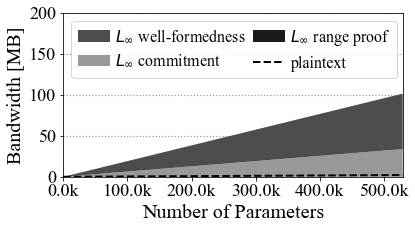


L2 Bandwidth:


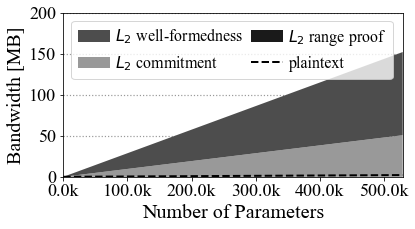

,n_weights,proving_bit_range,n_vector_segments,group_element_bytes,scalar_bytes,plaintext_bytes,l8_commitment_bytes,l2_commitment_bytes,l8_wellformedness_bytes,l2_wellformedness_bytes,l8_range_proof_bytes,l2_range_proof_bytes,l2_total_mb,l8_total_mb
0,1,8,4,32,32,4,64,96,128,192,352.0,736.0,0.001024,0.000544
8,4241,8,4,32,32,16964,271424,407136,542848,814272,1184.0,1568.0,1.222976,0.815456
16,8481,8,4,32,32,33924,542784,814176,1085568,1628352,1248.0,1632.0,2.444160,1.629600
24,12721,8,4,32,32,50884,814144,1221216,1628288,2442432,1248.0,1632.0,3.665280,2.443680
32,16961,8,4,32,32,67844,1085504,1628256,2171008,3256512,1312.0,1696.0,4.886464,3.257824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,508801,8,4,32,32,2035204,32563264,48844896,65126528,97689792,1568.0,1952.0,146.536640,97.691360
968,513041,8,4,32,32,2052164,32834624,49251936,65669248,98503872,1568.0,1952.0,147.757760,98.505440
976,517281,8,4,32,32,2069124,33105984,49658976,66211968,99317952,1568.0,1952.0,148.978880,99.319520
984,521521,8,4,32,32,2086084,33377344,50066016,66754688,100132032,1568.0,1952.0,150.200000,100.133600


In [8]:
# Bandwidth

def build_df_bandwidth(max_n_weights=10**6):
    
    n_steps = 1000
    step_size = int(max_n_weights / 1000)

    message_sizes = []
    for n_weights in range(1, max_n_weights, step_size):
        d = get_message_size(n_weights)
        message_sizes.append(d)

    df = pd.DataFrame(message_sizes)

    df["l2_total_mb"] = (df["l2_commitment_bytes"] + df["l2_wellformedness_bytes"] + df["l2_range_proof_bytes"]) * 1e-6
    df["l8_total_mb"] = (df["l8_commitment_bytes"] + df["l8_wellformedness_bytes"] + df["l8_range_proof_bytes"]) * 1e-6

    return df

def get_message_size(n_weights, proving_bit_range=8, n_vector_segments=4, group_element_bytes=32, scalar_bytes=32, plaintext_weight_bytes=4):    

    # n_weights: D
    # proving_bit_range: n
    # n_vector_segments: p

    d = {
        "n_weights": n_weights,
        "proving_bit_range": proving_bit_range,
        "n_vector_segments": n_vector_segments,
        "group_element_bytes": group_element_bytes,
        "scalar_bytes": scalar_bytes
    }


    d["plaintext_bytes"] = plaintext_weight_bytes * n_weights

    

    ###############################################################
    ## Commitments                                               ##
    ###############################################################

    # L8 / L8p
    d["l8_commitment_bytes"] = n_weights * 2 * group_element_bytes

    # L2: requires additional commitment to the squared parameters 
    # (pederson commitment => 1 group element per weight)
    d["l2_commitment_bytes"] = d["l8_commitment_bytes"] + n_weights * group_element_bytes
   
    
    ###############################################################
    ## Well-Formedness Proof                                     ##
    ###############################################################

    # L8 / L8p
    d["l8_wellformedness_bytes"] = (2 * scalar_bytes + 2 * group_element_bytes) * n_weights

    # L2: requires one additional scalar and group element for the square relation proof
    d["l2_wellformedness_bytes"] = d["l8_wellformedness_bytes"] + (scalar_bytes + group_element_bytes) * n_weights


    ###############################################################
    ## Range Proofs                                              ##
    ###############################################################   

    def next_pow(x):
        return pow(2, math.ceil(math.log(x, 2)))

    # L8 / L8p
    n_group_elements = 2 * (math.log(proving_bit_range, 2) + math.log(next_pow(n_weights / n_vector_segments), 2)) + 4
    n_scalars = 5
    d["l8_range_proof_bytes"] = n_group_elements * group_element_bytes + n_scalars * scalar_bytes

    # L2: requires additional group elements and scalars to proof that l2 norm is in range
    n_group_elements_additional  = math.log(proving_bit_range, 2) + 4
    n_scalars_additional = 5
    d["l2_range_proof_bytes"] = d["l8_range_proof_bytes"] + n_group_elements_additional * group_element_bytes + n_scalars_additional * scalar_bytes

    return d



def build_fig_mbench_bandwidth_perclient(df, norm):

    name = f"mbench_bandwidth_perclient_{norm}"

    if norm not in ["l2", "l8"]:
        raise ValueError("unknown norm")

    if norm == "l2":
        label_prefix = "$L_2$"
    else:
        label_prefix = "$L_{\infty}$"

    
    setup_plt()

    with PdfPages(f"{output_dir}/{name}.pdf") as pdf:
   
        fig, ax = plt.subplots()

        ##########################
        # Draw all the lines         
        ##########################

        ax.plot(df["n_weights"], df["plaintext_bytes"]*1e-6, label="plaintext", color="0.0", linestyle="--", linewidth=2)

        ax.stackplot(df["n_weights"], 
                    df[norm + "_commitment_bytes"]*1e-6, 
                    df[norm + "_wellformedness_bytes"]*1e-6, 
                    df[norm + "_range_proof_bytes"]*1e-6, 
                    colors=["0.6", "0.3", "0.1"], labels=[label_prefix + " commitment", label_prefix + " well-formedness", label_prefix + " range proof"], zorder=2)



        ##########################
        # General Format         
        ##########################
        #ax.set_title("Hello World")

        handles, labels = plt.gca().get_legend_handles_labels()
        order = [2,1,3,0]

        ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc="upper left", ncol=2, handletextpad=0.3, columnspacing=0.5)   # 'best', 'upper right', 'upper left', 'lower left', 
                                # 'lower right', 'right', 'center left',  'center right', 
                                # 'lower center', 'upper center', 'center'
        ax.grid(True, axis="y", linestyle=':', color='0.6', zorder=0, linewidth=1.2)


        ##########################
        # Y - Axis Format
        ##########################
        ax.set_ylim(ymin=0, ymax=200)
        ax.set_ylabel("Bandwidth [MB]")
        #ax.set_yticks(yticks)
        #ax.set_yticklabels(labels, fontsize=16, rotation=345)


        ##########################
        # X - Axis Format
        ##########################
        ax.set_xlim(xmin=0, xmax=530000)
        ax.set_xlabel("Number of Parameters")

        xlabels = [f"{round(x)}k" if x < 1000 else f"{round(x/1000)}M" for x in ax.get_xticks()/1000]
        ax.set_xticklabels(xlabels)

        pdf.savefig(bbox_inches='tight', pad_inches=0)
        plt.close()
    return fig


df = build_df_bandwidth(max_n_weights=530000)

output_dir = PAPER_DIR + "/plots/evaluation"

fig_mbench_bandwidth_perclient_l8 = build_fig_mbench_bandwidth_perclient(df, norm="l8")
print("L8 Bandwidth (infinity norm):")
display(fig_mbench_bandwidth_perclient_l8)

fig_mbench_bandwidth_perclient_l2 = build_fig_mbench_bandwidth_perclient(df, norm="l2")
print("\nL2 Bandwidth:")
display(fig_mbench_bandwidth_perclient_l2)

display(df[df.index % 8 == 0])





Probabilistic Checking:


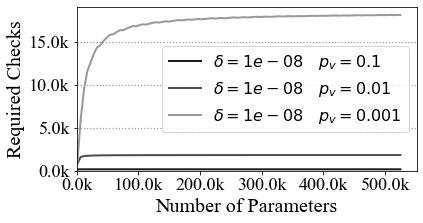

fail_prob_bound=1e-08 	 prob_weights_violating_bound=0.1
(n_weights, n_checks): [(1000, 160), (6290, 173), (11580, 174), (16870, 174), (22160, 175), (27450, 175), (32740, 175), (38030, 175), (43320, 175), (48610, 175), (53900, 175), (59190, 175), (64480, 175), (69770, 175), (75060, 175), (80350, 175), (85640, 175), (90930, 175), (96220, 175), (101510, 175), (106800, 175), (112090, 175), (117380, 175), (122670, 175), (127960, 175), (133250, 175), (138540, 175), (143830, 175), (149120, 175), (154410, 175), (159700, 175), (164990, 175), (170280, 175), (175570, 175), (180860, 175), (186150, 175), (191440, 175), (196730, 175), (202020, 175), (207310, 175), (212600, 175), (217890, 175), (223180, 175), (228470, 175), (233760, 175), (239050, 175), (244340, 175), (249630, 175), (254920, 175), (260210, 175), (265500, 175), (270790, 175), (276080, 175), (281370, 175), (286660, 175), (291950, 175), (297240, 175), (302530, 175), (307820, 175), (313110, 175), (318400, 175), (323690, 175), (328980, 1

In [10]:
# Probabilistic Checking

def detection_prop_hypergeometric(n_weights, n_weights_violating_bound, n_bounds_check):
    # probability that by sampling {n_bounds_check} weights without replacement from all the {n_weights} weights
    # we get k=0 of the {n_weights_violating_bound} weights that violate the bound
    hpd = ss.hypergeom(n_weights, n_weights_violating_bound, n_bounds_check)
    k = 0
    p = hpd.pmf(k)

    # probability that we get at least one of the weights violating the bound
    return 1 - p


def binary_search_nchecks(success_prob_bound, n_weights, n_weights_violating_bound):
    mid = 0
    start = 0
    end = n_weights # 10000 # upper bound
    step = 0
    success = None
    while (start <= end):
        mid = (start + end) // 2
        
        prob = detection_prop_hypergeometric(n_weights=n_weights, n_weights_violating_bound=n_weights_violating_bound, n_bounds_check=mid)
        #print(f"Check mid={mid}  prob={prob}")

        if prob < success_prob_bound:
            # checking {mid} parameters not sufficient => increase the number of checks
            start = mid + 1
        else:
            # checking {mid} parameters, results in success probability above the bound => check if reducing number of checks still works
            success = (mid, prob)
            end = mid - 1

    if success is None:
        raise ValueError("did not find satisfiable number of checks")
    return success

def build_prob_checking_data():
    lines = []

    x_min = 1000
    x_max = 530000

    n_steps = 100
    step_size = int((x_max-x_min)/n_steps)
    
    for fail_prob_bound, linestyle in tqdm(zip([1e-8], ['-'])): #, 1e-9


        success_prob_bound = 1 - fail_prob_bound
        for prob_weights_violating_bound, color in tqdm(zip([0.1, 0.01, 0.001], ['0.1', '0.3','0.6'])):

            labels = range(x_min, x_max, step_size)
            values = []
            for n_weights in tqdm(labels, leave=False):
                n_weights_violating_bound = int(prob_weights_violating_bound * n_weights)
                s = binary_search_nchecks(success_prob_bound=success_prob_bound, n_weights=n_weights, n_weights_violating_bound=n_weights_violating_bound)
                n_checks = s[0]
                values.append(n_checks)
            d = {
                "fail_prob_bound": fail_prob_bound,
                "success_prob_bound": success_prob_bound,
                "prob_weights_violating_bound": prob_weights_violating_bound,
                #"n_weights_violating_bound": n_weights_violating_bound,
                "labels (n_weights)": labels,
                "values (n_checks)": values,
                "color": color,
                "linestyle": linestyle
            }
            lines.append(d)

    return lines

def build_fig_pcheck_num_required_checks(lines, name="pcheck_num_required_checks"):

    setup_plt()

    with PdfPages(f"{output_dir}/{name}.pdf") as pdf:
   
        fig, ax = plt.subplots()

        ##########################
        # Draw all the lines         
        ##########################

        # lineplot
        for line in lines:

            fail_prob_bound = line["fail_prob_bound"]
            prob_weights_violating_bound = line["prob_weights_violating_bound"]
            label = f"$\delta = {fail_prob_bound}$    $p_v = {prob_weights_violating_bound}$"
            plt.plot(line["labels (n_weights)"], line["values (n_checks)"], label=label, color=line["color"], linestyle=line["linestyle"], linewidth=2)

        ##########################
        # General Format         
        ##########################
        #ax.set_title("Hello World")
        ax.legend(loc="best")   # 'best', 'upper right', 'upper left', 'lower left', 
                                # 'lower right', 'right', 'center left',  'center right', 
                                # 'lower center', 'upper center', 'center'
        ax.grid(True, axis="y", linestyle=':', color='0.6', zorder=0, linewidth=1.2)

        ##########################
        # Y - Axis Format
        ##########################
        ax.set_ylim(ymin=0, ymax=None)
        ax.set_ylabel("Required Checks")
        #ax.set_yticks(yticks)
        ylabels = [f"{round(y)}k" for y in ax.get_yticks()/1000]
        ax.set_yticklabels(ylabels)

        ##########################
        # X - Axis Format
        ##########################
        ax.set_xlim(xmin=0, xmax=None)
        ax.set_xlabel("Number of Parameters")
        #ax.set_xticks(xticks)
        xlabels = [f"{round(x)}k" for x in ax.get_xticks()/1000]
        ax.set_xticklabels(xlabels)

        pdf.savefig(bbox_inches='tight', pad_inches=0)
        plt.close()
    return fig



lines = build_prob_checking_data()

fig_pcheck_num_required_checks = build_fig_pcheck_num_required_checks(lines)

print("Probabilistic Checking:")
display(fig_pcheck_num_required_checks)

# print data
for line in lines:
    print(f"fail_prob_bound={line['fail_prob_bound']} \t prob_weights_violating_bound={line['prob_weights_violating_bound']}")

    lst = [(label, value) for label, value in zip(line["labels (n_weights)"], line["values (n_checks)"])]
    
    print(f"(n_weights, n_checks): {lst}")
    print("====================\n")

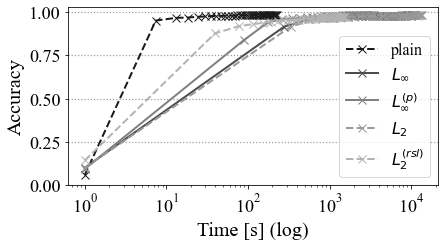

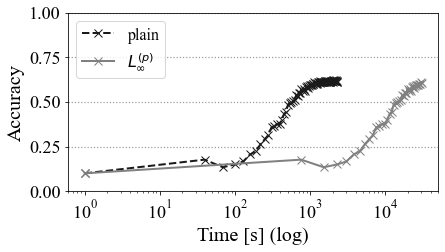

,epoch,loss_u,accuracy_u,time_u,cumtime_u,loss_l8,accuracy_l8,time_l8,cumtime_l8,loss_l8p,...,time_l8p,cumtime_l8p,loss_l2,accuracy_l2,time_l2,cumtime_l2,loss_l2rst,accuracy_l2rst,time_l2rst,cumtime_l2rst
0,0,2.320262,0.0574,1.000000,1.000000,2.336624,0.1002,1.000000,1.000000,2.415536,...,1.000000,1.000000,2.336624,0.1002,1.000000,1.000000,2.574258,0.1428,1.00000,1.000000
1,1,0.172427,0.9516,6.430499,7.430499,0.282723,0.9173,278.173548,279.173548,0.619241,...,87.649752,88.649752,0.282723,0.9173,335.282102,336.282102,0.428086,0.8777,38.49883,39.498830
2,2,0.113188,0.9671,5.622920,13.053419,0.138087,0.9589,278.173548,557.347096,0.187961,...,87.649752,176.299505,0.138087,0.9589,335.282102,671.564204,0.289831,0.9196,38.49883,77.997659
3,3,0.098994,0.9693,5.591158,18.644578,0.113191,0.9672,278.173548,835.520644,0.133701,...,87.649752,263.949257,0.113191,0.9672,335.282102,1006.846305,0.252063,0.9313,38.49883,116.496489
4,4,0.091006,0.9736,5.601222,24.245800,0.100314,0.9694,278.173548,1113.694192,0.114930,...,87.649752,351.599010,0.100314,0.9694,335.282102,1342.128407,0.230983,0.9394,38.49883,154.995318
5,5,0.084292,0.9753,5.598727,29.844527,0.090484,0.9719,278.173548,1391.867740,0.104646,...,87.649752,439.248762,0.090484,0.9719,335.282102,1677.410509,0.213896,0.9458,38.49883,193.494148
6,6,0.081022,0.9780,5.583597,35.428124,0.087058,0.9738,278.173548,1670.041288,0.096979,...,87.649752,526.898515,0.087058,0.9738,335.282102,2012.692611,0.203135,0.9493,38.49883,231.992977
7,7,0.077538,0.9783,5.581203,41.009326,0.082481,0.9756,278.173548,1948.214836,0.091339,...,87.649752,614.548267,0.082481,0.9756,335.282102,2347.974713,0.194712,0.9528,38.49883,270.491807
8,8,0.073688,0.9789,5.581732,46.591059,0.076003,0.9756,278.173548,2226.388384,0.086673,...,87.649752,702.198019,0.076003,0.9756,335.282102,2683.256814,0.188547,0.9544,38.49883,308.990636
9,9,0.072065,0.9795,5.580852,52.171911,0.076308,0.9764,278.173548,2504.561932,0.081851,...,87.649752,789.847772,0.076308,0.9764,335.282102,3018.538916,0.184577,0.9557,38.49883,347.489466


,epoch,loss_u,accuracy_u,time_u,cumtime_u,loss_l8p,accuracy_l8p,time_l8p,cumtime_l8p
0,0,35.111758,0.1000,1.000000,1.000000,35.111758,0.1000,1.000000,1.000000
1,1,2.441497,0.1767,38.329690,39.329690,2.441497,0.1767,756.443355,757.443355
2,2,2.516722,0.1341,29.537980,68.867670,2.516722,0.1341,756.443355,1513.886710
3,3,2.751854,0.1498,29.714327,98.581997,2.751854,0.1498,756.443355,2270.330065
4,4,3.012687,0.1665,29.888728,128.470725,3.012687,0.1665,756.443355,3026.773419
...,...,...,...,...,...,...,...,...,...
76,76,1.537239,0.6228,28.444442,2183.927049,NaN,NaN,NaN,NaN
77,77,1.581906,0.6164,28.511126,2212.438174,NaN,NaN,NaN,NaN
78,78,1.611568,0.6136,28.521966,2240.960140,NaN,NaN,NaN,NaN
79,79,1.585322,0.6128,28.500286,2269.460426,NaN,NaN,NaN,NaN


In [28]:
# End-to-End Plot
from functools import reduce

def _preprocess(df, suffix):
    # set start timestamp to 0
    df["time"].iloc[0] = 1
    df["cumtime"] = df["time"].cumsum()
    df = df.rename(columns={"loss": f"loss_{suffix}", "accuracy": f"accuracy_{suffix}", "time": f"time_{suffix}", "cumtime": f"cumtime_{suffix}" })
    return df


def build_df_e2e_mnist():
    data_folder = "data/endtoend/"
    csv_schema = ["epoch", "loss", "accuracy", "time"]

    df_u = _preprocess(pd.read_csv(data_folder + "mnist_plain_baseline.csv", names=csv_schema), suffix="u")

    df_l8 = pd.read_csv(data_folder + "mnist_range_old_slow.csv", names=csv_schema)
    df_l8_time = pd.read_csv(data_folder + "mnist_range_old.csv", names=csv_schema)
    # exclude first two rows because (1st row contains base timestamp and 2nd row is not representative for the optimized versions due to optimistic starting)
    df_l8["time"] = df_l8_time["time"][2:].mean() 
    df_l8 = _preprocess(df_l8, suffix="l8")

    df_l8p = pd.read_csv(data_folder + "mnist_range_optim_randproof.csv", names=csv_schema)
    df_l8p_time = pd.read_csv(data_folder + "mnist_range_optim.csv", names=csv_schema)
    df_l8p["time"] = df_l8p_time["time"][2:].mean()
    df_l8p = _preprocess(df_l8p, suffix="l8p")

    df_l2 = pd.read_csv(data_folder + "mnist_range_old_slow.csv", names=csv_schema)
    df_l2_time = pd.read_csv(data_folder + "mnist_l2_old.csv", names=csv_schema)
    df_l2["time"] = df_l2_time["time"][2:].mean()
    df_l2 = _preprocess(df_l2, suffix="l2")

    df_l2rst = pd.read_csv(data_folder + "mnist_l2_optim.csv", names=csv_schema)
    df_l2rst_time = pd.read_csv(data_folder + "mnist_l2_optim_timing.csv", names=csv_schema)
    df_l2rst["time"] = df_l2rst_time["time"][2:].mean()
    df_l2rst = _preprocess(df_l2rst, suffix="l2rst")


    data_frames = [df_u, df_l8, df_l8p, df_l2, df_l2rst]

    
    df = reduce(lambda  left, right: pd.merge(left, right, on=['epoch'], how='outer'), data_frames)

    
    return df


def build_fig_e2e_mnist_time(df, name="e2e_mnist_time"):

    configs = {
        "u": {"label": "plain",                 "color": "0.1", "linestyle": "--", "marker": "x"},
        "l8": {"label": "$L_{\infty}$",         "color": "0.3", "linestyle": "-", "marker": "x"},
        "l8p": {"label": "$L_{\infty}^{(p)}$",  "color": "0.5", "linestyle": "-", "marker": "x"},
        "l2": {"label": "$L_2$",                "color": "0.6", "linestyle": "--", "marker": "x"},
        "l2rst": {"label": "$L_2^{(rsl)}$",      "color": "0.7", "linestyle": "--", "marker": "x"}
    }
    setup_plt()

    with PdfPages(f"{output_dir}/{name}.pdf") as pdf:
   
        fig, ax = plt.subplots()

        ##########################
        # Draw all the lines         
        ##########################

        # lineplot
        for suffix in configs.keys():
            values = df[f"accuracy_{suffix}"]
            labels = df[f"cumtime_{suffix}"]
            config = configs[suffix]
            plt.plot(labels, values, label=config["label"], color=config["color"], linestyle=config["linestyle"], marker=config["marker"], linewidth=2, markersize=8)


        ##########################
        # General Format         
        ##########################
        #ax.set_title("Hello World")
        ax.legend(loc="best")   # 'best', 'upper right', 'upper left', 'lower left', 
                                # 'lower right', 'right', 'center left',  'center right', 
                                # 'lower center', 'upper center', 'center'
        ax.grid(True, axis="y", linestyle=':', color='0.6', zorder=0, linewidth=1.2)


        ##########################
        # Y - Axis Format
        ##########################
        ax.set_ylim(ymin=0, ymax=None)
        ax.set_ylabel("Accuracy")
        ax.set_yticks([0,0.25,0.5,0.75,1])
        #ax.set_yticklabels(labels, fontsize=16, rotation=345)


        ##########################
        # X - Axis Format
        ##########################
        #ax.set_xlim(xmin=-30, xmax=1000)
        ax.set_xlabel("Time [s] (log)")
        ax.set_xscale("log")
        #ax.set_xticks(xticks)
        #ax.set_xticklabels(labels, fontsize=16, rotation=345)

        pdf.savefig(bbox_inches='tight', pad_inches=0)
        plt.close()
    return fig

def build_df_e2e_cifar():

    data_folder = "data/endtoend_extra/"
    csv_schema = ["epoch", "loss", "accuracy", "time"]

    df_u = _preprocess(pd.read_csv(data_folder + "cifar_resnet_plain.csv", names=csv_schema), suffix="u")
    
    df_l8p = pd.read_csv(data_folder + "cifar_resnet_linf_simul.csv", names=csv_schema)
    df_l8p_time = pd.read_csv(data_folder + "cifar_resnet_linfopt05percent.csv", names=csv_schema)
    df_l8p["time"] = df_l8p_time["time"][2:].mean()
    df_l8p = _preprocess(df_l8p, suffix="l8p")

    data_frames = [df_u, df_l8p]
    df = reduce(lambda  left, right: pd.merge(left, right, on=['epoch'], how='outer'), data_frames)

    return df

def build_fig_e2e_cifar_time(df, name="e2e_cifar_time"):

    configs = {
        "u": {"label": "plain",                 "color": "0.1", "linestyle": "--", "marker": "x"},
        "l8p": {"label": "$L_{\infty}^{(p)}$",  "color": "0.5", "linestyle": "-", "marker": "x"}
    }
    setup_plt()

    with PdfPages(f"{output_dir}/{name}.pdf") as pdf:
   
        fig, ax = plt.subplots()

        ##########################
        # Draw all the lines         
        ##########################

        # lineplot
        for suffix in configs.keys():
            values = df[f"accuracy_{suffix}"]
            labels = df[f"cumtime_{suffix}"]
            config = configs[suffix]
            plt.plot(labels, values, label=config["label"], color=config["color"], linestyle=config["linestyle"], marker=config["marker"], linewidth=2, markersize=8)


        ##########################
        # General Format         
        ##########################
        #ax.set_title("Hello World")
        ax.legend(loc="upper left")   # 'best', 'upper right', 'upper left', 'lower left', 
                                # 'lower right', 'right', 'center left',  'center right', 
                                # 'lower center', 'upper center', 'center'
        ax.grid(True, axis="y", linestyle=':', color='0.6', zorder=0, linewidth=1.2)


        ##########################
        # Y - Axis Format
        ##########################
        ax.set_ylim(ymin=0, ymax=None)
        ax.set_ylabel("Accuracy")
        ax.set_yticks([0,0.25,0.5,0.75,1])
        #ax.set_yticklabels(labels, fontsize=16, rotation=345)


        ##########################
        # X - Axis Format
        ##########################
        #ax.set_xlim(xmin=-30, xmax=1000)
        ax.set_xlabel("Time [s] (log)")
        ax.set_xscale("log")
        #ax.set_xticks(xticks)
        #ax.set_xticklabels(labels, fontsize=16, rotation=345)

        pdf.savefig(bbox_inches='tight', pad_inches=0)
        plt.close()
    return fig


output_dir = PAPER_DIR + "/plots/evaluation"

df_mnist = build_df_e2e_mnist()
fig_e2e_mnist_time = build_fig_e2e_mnist_time(df_mnist)
display(fig_e2e_mnist_time)


df_cifar = build_df_e2e_cifar()
fig_e2e_cifar_time = build_fig_e2e_cifar_time(df_cifar)
display(fig_e2e_cifar_time)


display(df_mnist)
display(df_cifar)

In [14]:
# Analysis

L8 Bounds:


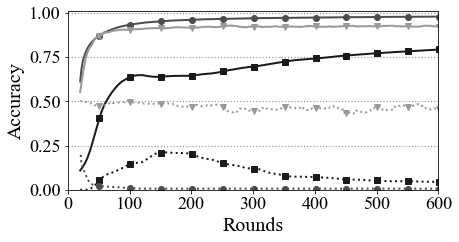

L2 Bounds:


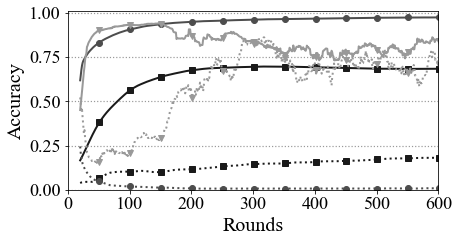

Legends:


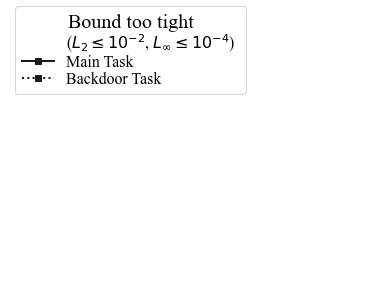

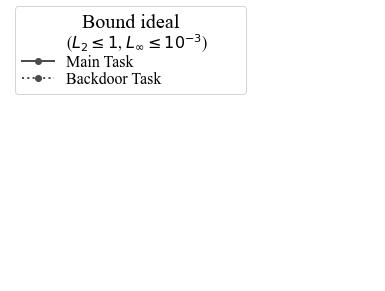

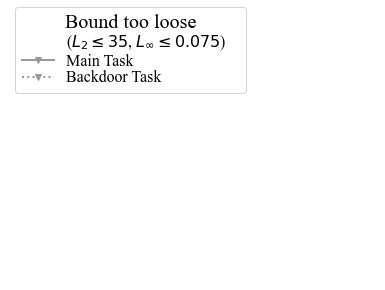

PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `./../../fl-project/plots/analysis/norm_accuracy_compare_plot_legend1.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `./../../fl-project/plots/analysis/norm_accuracy_compare_plot_legend2.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `./../../fl-project/plots/analysis/norm_accuracy_compare_plot_legend2.pdf'.
L8 Bounds:


,Round,e41_clipinf_0_0001_evaluation/test_accuracy,e41_clipinf_0_0001_evaluation/adv_success,e41_clipl2_40_pgd_evaluation/test_accuracy,e41_clipl2_40_pgd_evaluation/adv_success,e41_clipinf_0.005_alpha05_evaluation/test_accuracy,e41_clipinf_0.005_alpha05_evaluation/adv_success,e41_clipl2_3_5_evaluation/test_accuracy,e41_clipl2_3_5_evaluation/adv_success,e41_clipinf_0.0015_evaluation/test_accuracy,...,l2_bound_tootight_advsuccess_std,l2_bound_tootight_testaccuracy_std,l2_bound_ideal_advsuccess,l2_bound_ideal_testaccuracy,l2_bound_ideal_advsuccess_std,l2_bound_ideal_testaccuracy_std,l2_bound_tooloose_advsuccess,l2_bound_tooloose_testaccuracy,l2_bound_tooloose_advsuccess_std,l2_bound_tooloose_testaccuracy_std
9,10,0.102526,0.000000,0.112385,1.000000,0.806927,0.041935,0.808617,0.045161,0.627254,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,20,0.156507,0.000000,0.616598,0.567742,0.887076,0.016129,0.890604,0.016129,0.771752,...,0.012642,0.040244,0.245323,0.619387,0.204518,0.192560,0.522581,0.451092,0.397792,0.313743
29,30,0.253452,0.006410,0.869783,0.116129,0.926220,0.009677,0.928326,0.009677,0.826254,...,0.004499,0.044421,0.103871,0.759806,0.035991,0.030861,0.250000,0.771478,0.211700,0.164373
39,40,0.396348,0.051282,0.908289,0.100000,0.943465,0.009677,0.945645,0.006452,0.860401,...,0.005326,0.042120,0.062419,0.802356,0.013250,0.020237,0.164032,0.869855,0.076130,0.032297
49,50,0.488837,0.080711,0.848569,0.480645,0.950519,0.012903,0.951769,0.009677,0.880389,...,0.015104,0.032953,0.049677,0.830961,0.003033,0.013682,0.167258,0.900066,0.083951,0.017646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849,1850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1859,1860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1869,1870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1879,1880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


L2 Bounds:


,Round,e41_clipinf_0_0001_evaluation/test_accuracy,e41_clipinf_0_0001_evaluation/adv_success,e41_clipl2_40_pgd_evaluation/test_accuracy,e41_clipl2_40_pgd_evaluation/adv_success,e41_clipinf_0.005_alpha05_evaluation/test_accuracy,e41_clipinf_0.005_alpha05_evaluation/adv_success,e41_clipl2_3_5_evaluation/test_accuracy,e41_clipl2_3_5_evaluation/adv_success,e41_clipinf_0.0015_evaluation/test_accuracy,...,l2_bound_tootight_advsuccess_std,l2_bound_tootight_testaccuracy_std,l2_bound_ideal_advsuccess,l2_bound_ideal_testaccuracy,l2_bound_ideal_advsuccess_std,l2_bound_ideal_testaccuracy_std,l2_bound_tooloose_advsuccess,l2_bound_tooloose_testaccuracy,l2_bound_tooloose_advsuccess_std,l2_bound_tooloose_testaccuracy_std
9,10,0.102526,0.000000,0.112385,1.000000,0.806927,0.041935,0.808617,0.045161,0.627254,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,20,0.156507,0.000000,0.616598,0.567742,0.887076,0.016129,0.890604,0.016129,0.771752,...,0.012642,0.040244,0.245323,0.619387,0.204518,0.192560,0.522581,0.451092,0.397792,0.313743
29,30,0.253452,0.006410,0.869783,0.116129,0.926220,0.009677,0.928326,0.009677,0.826254,...,0.004499,0.044421,0.103871,0.759806,0.035991,0.030861,0.250000,0.771478,0.211700,0.164373
39,40,0.396348,0.051282,0.908289,0.100000,0.943465,0.009677,0.945645,0.006452,0.860401,...,0.005326,0.042120,0.062419,0.802356,0.013250,0.020237,0.164032,0.869855,0.076130,0.032297
49,50,0.488837,0.080711,0.848569,0.480645,0.950519,0.012903,0.951769,0.009677,0.880389,...,0.015104,0.032953,0.049677,0.830961,0.003033,0.013682,0.167258,0.900066,0.083951,0.017646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849,1850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1859,1860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1869,1870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1879,1880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
%run extract_histogram.py
%run plots.py

output_dir = PAPER_DIR + "/plots/analysis"

#fig = norm_accuracy_compare_plot("l2_norm_accuracy_compare_plot.pdf", "L2")
fig, df_l8 = norm_accuracy_compare_plot("norm_accuracy_compare_plot_l8", norm="l8", legend_type=None, use_error=False, output_dir=output_dir)
#, ignore_error=["l8_bound_tooloose_advsuccess"])
print("L8 Bounds:")
display(fig)

fig, df_l2 = norm_accuracy_compare_plot("norm_accuracy_compare_plot_l2", norm="l2", legend_type=None, use_error=False, output_dir=output_dir)
print("L2 Bounds:")
display(fig)

legend1, _ = norm_accuracy_compare_plot("norm_accuracy_compare_plot_legend1", norm="l8", legend_type="tootight", use_error=False, output_dir=output_dir)
legend2, _ = norm_accuracy_compare_plot("norm_accuracy_compare_plot_legend2", norm="l8", legend_type="ideal", use_error=False, output_dir=output_dir)
legend3, _ = norm_accuracy_compare_plot("norm_accuracy_compare_plot_legend3", norm="l8", legend_type="tooloose", use_error=False, output_dir=output_dir)

print("Legends:")
display(legend1)
display(legend2)
display(legend3)

l1 = output_dir + "/norm_accuracy_compare_plot_legend1.pdf"
l2 = output_dir + "/norm_accuracy_compare_plot_legend2.pdf"
l3 = output_dir + "/norm_accuracy_compare_plot_legend2.pdf"

# crop the legend
!pdfcrop $l1 $l1

!pdfcrop $l2 $l2

!pdfcrop $l3 $l3

print("L8 Bounds:")
display(df_l8[df_l8["Round"]%10==0])

print("L2 Bounds:")
display(df_l2[df_l2["Round"]%10==0])


L8 Bounds:


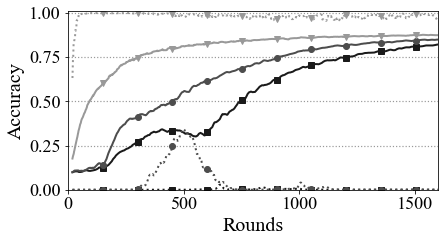

L2 Bounds:


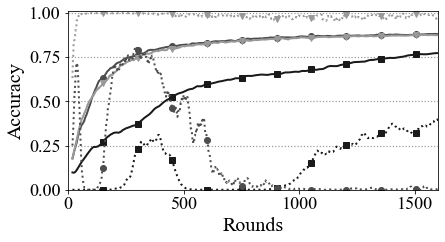

Legends:


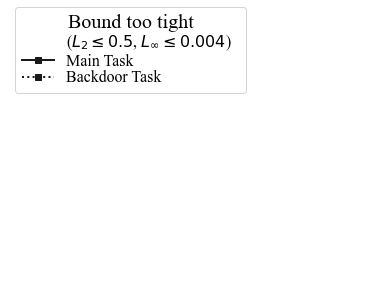

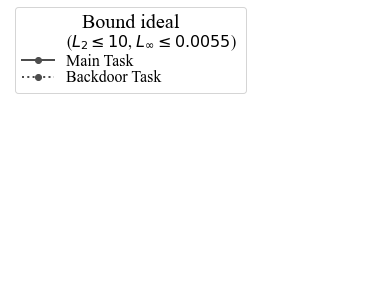

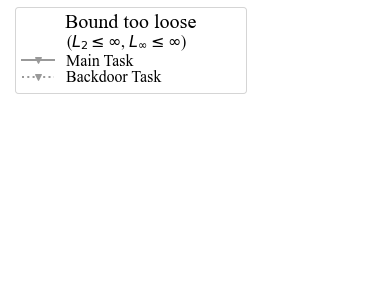

PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.

!!! Warning: Empty Bounding Box is returned by Ghostscript!
!!!   Page 1: 0 0 0 0
!!! Either there is a problem with the page or with Ghostscript.
!!! Recovery is tried by embedding the page in its original size.

==> 1 page written on `norm_accuracy_compare_plot_legend1_cifar.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `norm_accuracy_compare_plot_legend2_cifar.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `norm_accuracy_compare_plot_legend3_cifar.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `./../../fl-project/plots/analysis/norm_accuracy_compare_plot_legend1_cifar.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `./../../fl-project/plots/analysis/norm_accuracy_compare_plot_legend2_cifar.pdf'.
PDFCROP 1.38, 201

,Round,e58_lr1_cifar_clip_0.004_evaluation/test_accuracy,e58_lr1_cifar_clip_0.004_evaluation/adv_success,e58_lr1_cifar_clip_0.0055_evaluation/test_accuracy,e58_lr1_cifar_clip_0.0055_evaluation/adv_success,e58_lr1_cifar_baseline_evaluation/test_accuracy,e58_lr1_cifar_baseline_evaluation/adv_success,e58_lr1_cifar_clipl2_0.5_evaluation/test_accuracy,e58_lr1_cifar_clipl2_0.5_evaluation/adv_success,e58_lr1_cifar_clipl2_20_evaluation/test_accuracy,...,l2_bound_tootight_advsuccess_std,l2_bound_tootight_testaccuracy_std,l2_bound_ideal_advsuccess,l2_bound_ideal_testaccuracy,l2_bound_ideal_advsuccess_std,l2_bound_ideal_testaccuracy_std,l2_bound_tooloose_advsuccess,l2_bound_tooloose_testaccuracy,l2_bound_tooloose_advsuccess_std,l2_bound_tooloose_testaccuracy_std
9,10,0.099821,0.0,0.099821,0.0,0.189291,0.826042,0.094248,0.0,0.167297,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,20,0.100119,0.0,0.100816,0.0,0.220740,1.000000,0.090565,0.0,0.211385,...,0.0,0.006662,0.250104,0.177752,0.214463,0.047279,0.632552,0.176806,0.394057,0.040475
29,30,0.102209,0.0,0.103404,0.0,0.315884,0.995313,0.109773,0.0,0.275179,...,0.0,0.006876,0.552005,0.229309,0.236404,0.022252,0.858307,0.234022,0.239908,0.038961
39,40,0.100119,0.0,0.103006,0.0,0.365645,1.000000,0.136047,0.0,0.330514,...,0.0,0.012996,0.707161,0.279255,0.212874,0.045344,0.957526,0.293655,0.094517,0.046956
49,50,0.100717,0.0,0.102209,0.0,0.408340,1.000000,0.158141,0.0,0.414709,...,0.0,0.013232,0.469896,0.336311,0.308440,0.024164,0.992891,0.351115,0.011111,0.032643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2279,2280,NaN,NaN,NaN,NaN,0.881469,0.987500,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.977839,0.881613,0.038013,0.002452
2289,2290,NaN,NaN,NaN,NaN,0.885748,0.998438,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.976719,0.881897,0.038548,0.002410
2299,2300,NaN,NaN,NaN,NaN,0.881369,1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.985208,0.882519,0.031323,0.002637
2309,2310,NaN,NaN,NaN,NaN,0.882663,0.993750,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.987891,0.881126,0.021352,0.003474


L2 Bounds:


,Round,e58_lr1_cifar_clip_0.004_evaluation/test_accuracy,e58_lr1_cifar_clip_0.004_evaluation/adv_success,e58_lr1_cifar_clip_0.0055_evaluation/test_accuracy,e58_lr1_cifar_clip_0.0055_evaluation/adv_success,e58_lr1_cifar_baseline_evaluation/test_accuracy,e58_lr1_cifar_baseline_evaluation/adv_success,e58_lr1_cifar_clipl2_0.5_evaluation/test_accuracy,e58_lr1_cifar_clipl2_0.5_evaluation/adv_success,e58_lr1_cifar_clipl2_20_evaluation/test_accuracy,...,l2_bound_tootight_advsuccess_std,l2_bound_tootight_testaccuracy_std,l2_bound_ideal_advsuccess,l2_bound_ideal_testaccuracy,l2_bound_ideal_advsuccess_std,l2_bound_ideal_testaccuracy_std,l2_bound_tooloose_advsuccess,l2_bound_tooloose_testaccuracy,l2_bound_tooloose_advsuccess_std,l2_bound_tooloose_testaccuracy_std
9,10,0.099821,0.0,0.099821,0.0,0.189291,0.826042,0.094248,0.0,0.167297,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,20,0.100119,0.0,0.100816,0.0,0.220740,1.000000,0.090565,0.0,0.211385,...,0.0,0.006662,0.250104,0.177752,0.214463,0.047279,0.632552,0.176806,0.394057,0.040475
29,30,0.102209,0.0,0.103404,0.0,0.315884,0.995313,0.109773,0.0,0.275179,...,0.0,0.006876,0.552005,0.229309,0.236404,0.022252,0.858307,0.234022,0.239908,0.038961
39,40,0.100119,0.0,0.103006,0.0,0.365645,1.000000,0.136047,0.0,0.330514,...,0.0,0.012996,0.707161,0.279255,0.212874,0.045344,0.957526,0.293655,0.094517,0.046956
49,50,0.100717,0.0,0.102209,0.0,0.408340,1.000000,0.158141,0.0,0.414709,...,0.0,0.013232,0.469896,0.336311,0.308440,0.024164,0.992891,0.351115,0.011111,0.032643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2279,2280,NaN,NaN,NaN,NaN,0.881469,0.987500,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.977839,0.881613,0.038013,0.002452
2289,2290,NaN,NaN,NaN,NaN,0.885748,0.998438,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.976719,0.881897,0.038548,0.002410
2299,2300,NaN,NaN,NaN,NaN,0.881369,1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.985208,0.882519,0.031323,0.002637
2309,2310,NaN,NaN,NaN,NaN,0.882663,0.993750,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.987891,0.881126,0.021352,0.003474


In [18]:
%run extract_histogram.py
%run plots.py

xmax = 1600

output_dir = PAPER_DIR + "/plots/analysis"

fig, df_l8 = norm_accuracy_compare_plot("norm_accuracy_compare_plot_l8_cifar", norm="l8", legend_type=None, use_error=False, model="cifar", xmax=xmax, output_dir=output_dir, markevery=150)
print("L8 Bounds:")
display(fig)

fig, df_l2 = norm_accuracy_compare_plot("norm_accuracy_compare_plot_l2_cifar", norm="l2", legend_type=None, use_error=False, model="cifar", xmax=xmax, output_dir=output_dir, markevery=150)
print("L2 Bounds:")
display(fig)

legend1, _ = norm_accuracy_compare_plot("norm_accuracy_compare_plot_legend1_cifar", norm="l2", legend_type="tootight", use_error=False, model="cifar", xmax=xmax, output_dir=output_dir)
legend2, _ = norm_accuracy_compare_plot("norm_accuracy_compare_plot_legend2_cifar", norm="l2", legend_type="ideal", use_error=False, model="cifar", xmax=xmax, output_dir=output_dir)
legend3, _ = norm_accuracy_compare_plot("norm_accuracy_compare_plot_legend3_cifar", norm="l2", legend_type="tooloose", use_error=False, model="cifar", xmax=xmax, output_dir=output_dir)

print("Legends:")
display(legend1)
display(legend2)
display(legend3)

# crop the legend
!pdfcrop norm_accuracy_compare_plot_legend1_cifar.pdf norm_accuracy_compare_plot_legend1_cifar.pdf

!pdfcrop norm_accuracy_compare_plot_legend2_cifar.pdf norm_accuracy_compare_plot_legend2_cifar.pdf

!pdfcrop norm_accuracy_compare_plot_legend3_cifar.pdf norm_accuracy_compare_plot_legend3_cifar.pdf

l1 = output_dir + "/norm_accuracy_compare_plot_legend1_cifar.pdf"
l2 = output_dir + "/norm_accuracy_compare_plot_legend2_cifar.pdf"
l3 = output_dir + "/norm_accuracy_compare_plot_legend2_cifar.pdf"

# crop the legend
!pdfcrop $l1 $l1
!pdfcrop $l2 $l2
!pdfcrop $l3 $l3

print("L8 Bounds:")
display(df_l8[df_l8["Round"]%10==0])

print("L2 Bounds:")
display(df_l2[df_l2["Round"]%10==0])

L2 Bound Figure:


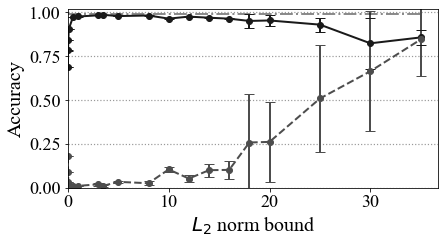

Skipped (ignored): e41_clipinf_0_03_evaluation/test_accuracy
Skipped (ignored): e41_clipinf_0_03_evaluation/adv_success
Skipped: e41_clipinf_0_00005_2_evaluation/test_accuracy
Skipped: e41_clipinf_0_00005_2_evaluation/adv_success
L8 Bound Figure:


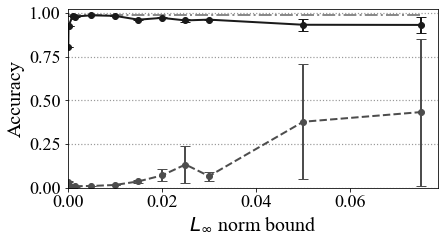

Skipped (ignored): e41_clipinf_0_03_evaluation/test_accuracy
Skipped (ignored): e41_clipinf_0_03_evaluation/adv_success
Skipped: e41_clipinf_0_00005_2_evaluation/test_accuracy
Skipped: e41_clipinf_0_00005_2_evaluation/adv_success


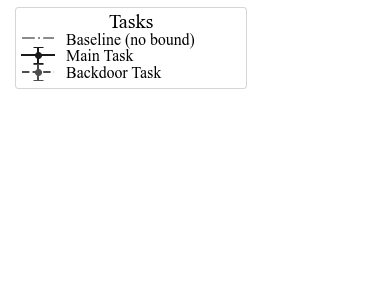

PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `./../../fl-project/plots/analysis/norm_accuracy_tradeoff_plot_legend.pdf'.
L2 Bound Data:


,round,norm,bound,test_accuracy_mean,test_accuracy_std,adv_success_mean,adv_success_std,baseline_mean,baseline_std
0,670,l2,0.010,0.686660,0.000217,0.180645,0.000000e+00,0.989269,0.000155
1,670,l2,0.025,0.783232,0.000986,0.087097,3.502109e-09,0.989269,0.000155
2,670,l2,0.050,0.844262,0.000844,0.031129,1.578582e-03,0.989269,0.000155
3,670,l2,0.100,0.906110,0.000620,0.016129,0.000000e+00,0.989269,0.000155
4,670,l2,0.500,0.972157,0.000299,0.006452,0.000000e+00,0.989269,0.000155
5,670,l2,1.000,0.977089,0.000320,0.009194,1.181766e-03,0.989269,0.000155
6,670,l2,3.000,0.983685,0.000544,0.018065,7.129113e-03,0.989269,0.000155
7,670,l2,3.500,0.986758,0.000255,0.009355,3.901970e-03,0.989269,0.000155
8,670,l2,5.000,0.979518,0.000927,0.032258,6.619215e-03,0.989269,0.000155
9,670,l2,8.000,0.982782,0.000474,0.024355,1.158244e-02,0.989269,0.000155


L8 Bound Data:


,round,norm,bound,test_accuracy_mean,test_accuracy_std,adv_success_mean,adv_success_std,baseline_mean,baseline_std
0,670,l8,0.00010,0.806067,0.000876,0.035839,1.122536e-03,0.989269,0.000155
1,670,l8,0.00015,0.923160,0.000593,0.016129,0.000000e+00,0.989269,0.000155
2,670,l8,0.00100,0.980889,0.000182,0.006452,3.910496e-09,0.989269,0.000155
3,670,l8,0.00150,0.978587,0.000421,0.009032,1.687575e-03,0.989269,0.000155
4,670,l8,0.00500,0.985520,0.000348,0.010484,1.774579e-03,0.989269,0.000155
5,670,l8,0.01000,0.982415,0.000311,0.016129,1.480102e-03,0.989269,0.000155
6,670,l8,0.01500,0.960662,0.002896,0.036613,7.989465e-03,0.989269,0.000155
7,670,l8,0.02000,0.970859,0.002282,0.070645,3.455173e-02,0.989269,0.000155
8,670,l8,0.02500,0.956478,0.008703,0.133065,1.076863e-01,0.989269,0.000155
9,670,l8,0.03000,0.960849,0.004230,0.066623,2.598280e-02,0.989269,0.000155


In [20]:
%run extract_histogram.py
%run plots.py

output_dir = PAPER_DIR + "/plots/analysis"

fig, df_l2 = norm_accuracy_tradeoff_plot(plotname="norm_accuracy_tradeoff_plot_l2", norm="l2", xtickspacing=10, add_legend=False, output_dir=output_dir)
print("L2 Bound Figure:")
display(fig)

fig, df_l8 = norm_accuracy_tradeoff_plot(plotname="norm_accuracy_tradeoff_plot_l8", norm="l8", xtickspacing=0.02, add_legend=False, output_dir=output_dir)
print("L8 Bound Figure:")
display(fig)

leg, _ = norm_accuracy_tradeoff_plot(plotname="norm_accuracy_tradeoff_plot_legend", norm="l8", xtickspacing=0.02, add_legend=True, output_dir=output_dir)
display(leg)


l1 = output_dir + "/norm_accuracy_tradeoff_plot_legend.pdf"
# crop the legend
!pdfcrop  $l1 $l1

print("L2 Bound Data:")
display(df_l2)

print("L8 Bound Data:")
display(df_l8)


/Users/hidde/opt/anaconda3/envs/backdoor_federated_learning/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/hidde/opt/anaconda3/envs/backdoor_federated_learning/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/hidde/opt/anaconda3/envs/backdoor_federated_learning/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


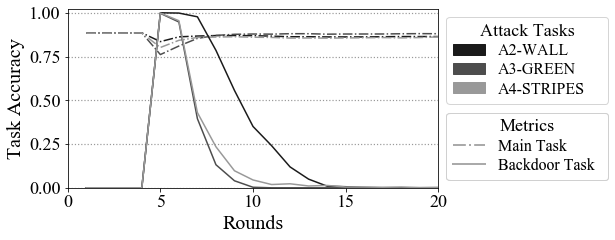

,round,a2-wall_testacc,a3-green_testacc,a4-stripes_testacc,a2-wall_advsucc,a3-green_advsucc,a4-stripes_advsucc
0,1,0.883260,0.883559,0.883360,0.000000,0.000000,0.000000
1,2,0.883559,0.883957,0.883360,0.000000,0.000000,0.000000
2,3,0.884057,0.884256,0.884057,0.000000,0.000000,0.000000
3,4,0.885450,0.885151,0.884853,0.000000,0.000000,0.000000
4,5,0.835291,0.761246,0.801752,1.000000,0.996875,0.998438
5,6,0.862460,0.810111,0.842655,0.998438,0.947396,0.954687
6,7,0.867138,0.853603,0.858977,0.977083,0.394792,0.429688
7,8,0.869825,0.870721,0.861365,0.785417,0.131771,0.234375
8,9,0.870024,0.877090,0.863057,0.556250,0.040104,0.097396
9,10,0.869327,0.878682,0.860470,0.350521,0.003125,0.044792


In [10]:
# cifar resnet18 model replacement

# %run extract_histogram.py
# %pwd
%run plots.py
output_dir = PAPER_DIR + "/plots"
fig, df = modelreplacement_cifar_resnet18_plot("modelreplacement_cifar_resnet18", output_dir=output_dir)

display(fig)
display(df[df["round"]<=30])


/Users/hidde/opt/anaconda3/envs/backdoor_federated_learning/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/hidde/opt/anaconda3/envs/backdoor_federated_learning/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/hidde/opt/anaconda3/envs/backdoor_federated_learning/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


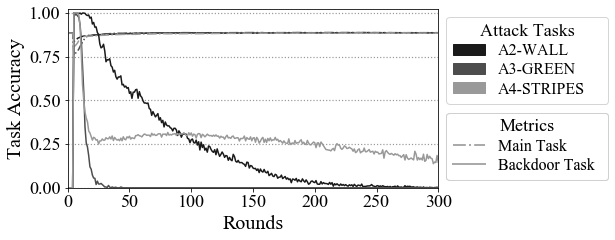

,round,a2-wall_testacc,a3-green_testacc,a4-stripes_testacc,a2-wall_advsucc,a3-green_advsucc,a4-stripes_advsucc
0,1,0.883260,0.883260,0.883260,0.000000,0.000000,0.000000
1,2,0.883559,0.883459,0.883459,0.000000,0.000000,0.000000
2,3,0.883758,0.883857,0.883857,0.000000,0.000000,0.000000
3,4,0.883857,0.883857,0.883658,0.000000,0.000000,0.000000
4,5,0.835987,0.758061,0.805533,1.000000,0.996875,1.000000
...,...,...,...,...,...,...,...
295,296,0.885450,0.886047,0.884355,0.000000,0.000000,0.137500
296,297,0.885052,0.886246,0.884256,0.001563,0.000000,0.147396
297,298,0.885052,0.886346,0.884057,0.001563,0.000000,0.144271
298,299,0.885151,0.886445,0.884057,0.003125,0.000000,0.184896


In [12]:
# cifar resnet18 model replacement (lower benign lr)

# %run extract_histogram.py
# %pwd
%run plots.py
output_dir = PAPER_DIR + "/plots"
fig, df = modelreplacement_cifar_resnet18_lowerlr_plot("modelreplacement_cifar_resnet18", output_dir=output_dir)

display(fig)
display(df[df["round"]<=30])

In [ ]:
# cifar resnet56 model replacement

%run extract_histogram.py
%run plots.py
output_dir = PAPER_DIR + "/plots/analysis"
fig, df = modelreplacement_cifar_resnet56_plot("modelreplacement_cifar", output_dir=output_dir)

display(fig)

display(df[df["round"]<=300])

/Users/hidde/opt/anaconda3/envs/backdoor_federated_learning/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/hidde/opt/anaconda3/envs/backdoor_federated_learning/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/hidde/opt/anaconda3/envs/backdoor_federated_learning/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


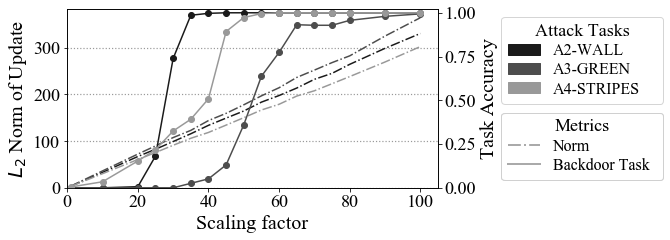

,scaling_factor,n_clients,a2-wall_bdoor,a2-wall_l2norm,a3-green_bdoor,a3-green_l2norm,a4-stripes_bdoor,a4-stripes_l2norm,alpha_fracadv
0,1,40,0.000000,3.283569,0.000000,3.508968,0.004688,2.978506,0.025
1,10,40,0.000000,33.129143,0.000000,36.147034,0.034375,30.234747,0.025
2,20,40,0.006250,67.015503,0.000000,72.201355,0.153125,60.591248,0.025
3,25,40,0.181250,82.607323,0.000000,89.749947,0.217708,75.526344,0.025
4,30,40,0.739062,99.061546,0.000000,107.568840,0.324479,91.086853,0.025
5,35,40,0.985937,115.745514,0.025521,122.981232,0.391667,106.067093,0.025
6,40,40,0.996875,133.780884,0.051042,143.995026,0.508333,118.561409,0.025
7,45,40,1.000000,149.305481,0.130729,159.473038,0.892708,134.303101,0.025
8,50,40,1.000000,164.498581,0.359896,177.766617,0.972917,150.183365,0.025
9,55,40,1.000000,183.500549,0.637500,196.961319,0.995313,166.650650,0.025


In [11]:
# scaling factor adv success
%run extract_histogram.py
%run plots.py
%run extract_tfevents.py
output_dir = PAPER_DIR + "/plots"
df = create_df_scaling_factor_cifar(prefix="e1_cifar_resnet18_scaling_factor_",
                              directory="scaling_factor")
fig, df = scaling_factor_adv_success("scaling_factor_adv_success_resnet18",
                                           output_dir=output_dir,
                                            df=df)

display(fig)
display(df)

/Users/hidde/opt/anaconda3/envs/backdoor_federated_learning/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/hidde/opt/anaconda3/envs/backdoor_federated_learning/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/hidde/opt/anaconda3/envs/backdoor_federated_learning/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


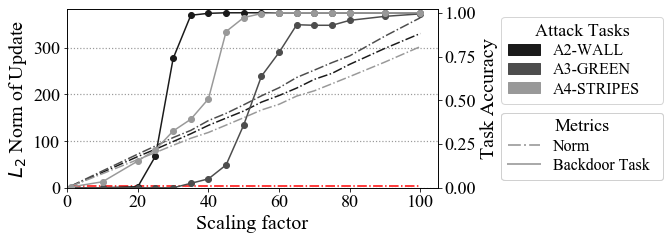

,scaling_factor,n_clients,a2-wall_bdoor,a2-wall_l2norm,a3-green_bdoor,a3-green_l2norm,a4-stripes_bdoor,a4-stripes_l2norm,alpha_fracadv
0,1,40,0.000000,3.283569,0.000000,3.508968,0.004688,2.978506,0.025
1,10,40,0.000000,33.129143,0.000000,36.147034,0.034375,30.234747,0.025
2,20,40,0.006250,67.015503,0.000000,72.201355,0.153125,60.591248,0.025
3,25,40,0.181250,82.607323,0.000000,89.749947,0.217708,75.526344,0.025
4,30,40,0.739062,99.061546,0.000000,107.568840,0.324479,91.086853,0.025
5,35,40,0.985937,115.745514,0.025521,122.981232,0.391667,106.067093,0.025
6,40,40,0.996875,133.780884,0.051042,143.995026,0.508333,118.561409,0.025
7,45,40,1.000000,149.305481,0.130729,159.473038,0.892708,134.303101,0.025
8,50,40,1.000000,164.498581,0.359896,177.766617,0.972917,150.183365,0.025
9,55,40,1.000000,183.500549,0.637500,196.961319,0.995313,166.650650,0.025


In [11]:
# scaling factor adv success
%run extract_histogram.py
%run plots.py
%run extract_tfevents.py
output_dir = PAPER_DIR + "/plots"
df = create_df_scaling_factor_cifar(prefix="e1_cifar_resnet18_scaling_factor_",
                              directory="scaling_factor")

benign_stats = create_df_benign_norms_statistics("scaling_factor/benign_norms")

fig, df = scaling_factor_adv_success_benign_norms("scaling_factor_adv_success_wr_resnet18",
                                           output_dir=output_dir,
                                            df_adv=df,
                                     df_stats=benign_stats)

display(fig)
display(df)

no match: cifar_resnet18_racingstripes_40.csv
Ignore file: cifar_lenet_minloss_wr_bgwall_30.csv with n_clients=30
no match: cifar_resnet18_bgwall_40.csv
Ignore file: cifar_lenet_minloss_wr_racingstripes_30.csv with n_clients=30
no match: cifar_resnet18_greencar_40.csv
Ignore file: cifar_lenet_minloss_wr_greencar_30.csv with n_clients=30


/Users/hidde/opt/anaconda3/envs/backdoor_federated_learning/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/hidde/opt/anaconda3/envs/backdoor_federated_learning/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/hidde/opt/anaconda3/envs/backdoor_federated_learning/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


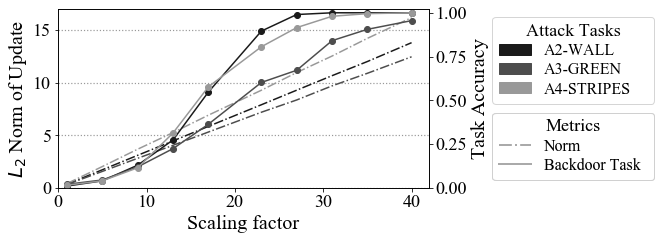

,scaling_factor,n_clients,a3-green_bdoor,a3-green_l2norm,a4-stripes_bdoor,a4-stripes_l2norm,a2-wall_bdoor,a2-wall_l2norm,alpha_fracadv
0,1,40,0.019900,0.313420,0.014925,0.405354,0.009950,0.343513,0.025
1,5,40,0.044776,1.559536,0.039801,2.021766,0.039801,1.714733,0.025
2,9,40,0.119403,2.806004,0.114428,3.670761,0.129353,3.089593,0.025
3,13,40,0.223881,4.041840,0.313433,5.251290,0.273632,4.457260,0.025
4,17,40,0.363184,5.300505,0.577114,6.903742,0.547264,5.839682,0.025
5,23,40,0.601990,7.183391,0.805970,9.275148,0.895522,7.894639,0.025
6,27,40,0.671642,8.350116,0.915423,10.959595,0.990050,9.280039,0.025
7,31,40,0.840796,9.688821,0.980099,12.524423,1.000000,10.657923,0.025
8,35,40,0.905473,10.885862,0.995025,14.206391,1.000000,12.004683,0.025
9,40,40,0.955224,12.454804,1.000000,16.175232,1.000000,13.795316,0.025


In [29]:
# scaling factor adv success
%run extract_histogram.py
%run plots.py
output_dir = PAPER_DIR + "/plots"
fig, df = scaling_factor_adv_success("scaling_factor_adv_success_lenet",
                                           output_dir=output_dir, prefix="cifar_lenet_minloss_wr")

display(fig)

display(df)

In [14]:
# norm distribution benign
%run extract_histogram.py
%run plots.py

output_dir = PAPER_DIR + "/plots/analysis"
fig, df = norm_distribution_benign(plotname="norm_distribution_benign", output_dir=output_dir)

!ls $output_dir

display(fig)

display(df)

no match: cifar_resnet18_racingstripes_40.csv
Ignore file: cifar_lenet_minloss_wr_bgwall_30.csv with n_clients=30
no match: cifar_resnet18_bgwall_40.csv
Ignore file: cifar_lenet_minloss_wr_racingstripes_30.csv with n_clients=30
no match: cifar_resnet18_greencar_40.csv
Ignore file: cifar_lenet_minloss_wr_greencar_30.csv with n_clients=30
    scaling_factor  n_clients  a2-wall_bdoor  a2-wall_l2norm  a3-green_bdoor  \
0                1         40       0.009950        0.343513        0.019900   
1               10         40       0.039801        1.714733        0.044776   
2               20         40       0.129353        3.089593        0.119403   
3               25         40       0.273632        4.457260        0.223881   
4               30         40       0.547264        5.839682        0.363184   
5               35         40       0.895522        7.894639        0.601990   
6               40         40       0.990050        9.280039        0.671642   
7               45   

FileNotFoundError: [Errno 2] No such file or directory: './plots/analysis/norm_distribution_benign.pdf'